# ETL 

In [1]:
from fitizens_libraries.load_and_process_training_data import load_training_data
from fitizens_libraries.load_timeseries import load_timeseries_data
from custom_libraries.merge_data import merge_data
from fitizens_libraries.plot_labeled_sequences import plot_labeled_sequence
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
from fitizens_libraries.build_dataframe_from_list_of_signals import build_dataframe
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, roc_auc_score
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Creating Auxiliary Functions

def create_custom_dataframe(series):
    df =  series[["linAccX", "linAccY", "linAccZ", "gyroX", "gyroY", "gyroZ", "magnX", "magnY", "magnZ"]]
    return df

In [2]:
def create_custom_dataframe(series):
    df =  series[["linAccX", "linAccY", "linAccZ", "gyroX", "gyroY", "gyroZ", "magnX", "magnY", "magnZ"]]
    return df

In [3]:
def create_training_data_stats(df, target):
    stats_dict = {}
    series = create_custom_dataframe(df)
    
    for column in series.columns:
        mean = series[column].mean()
        std = series[column].std()
        median = series[column].median()
        skewness = series[column].skew()
        kurtosis = series[column].kurtosis()
        min_val = series[column].min()
        max_val = series[column].max()
        range_val = max_val - min_val
        quartile_25 = np.percentile(series[column], 25)
        quartile_75 = np.percentile(series[column], 75)
        iqr = quartile_75 - quartile_25
    

        stats_dict[f"{column}_mean"] = mean
        stats_dict[f"{column}_std"] = std
        stats_dict[f"{column}_median"] = median
        stats_dict[f"{column}_skewness"] = skewness
        stats_dict[f"{column}_kurtosis"] = kurtosis
        stats_dict[f"{column}_min"] = min_val
        stats_dict[f"{column}_max"] = max_val
        stats_dict[f"{column}_range"] = range_val
        stats_dict[f"{column}_quartile_25"] = quartile_25
        stats_dict[f"{column}_quartile_75"] = quartile_75
        stats_dict[f"{column}_iqr"] = iqr
          
    stats_dict["target"] = target
    return stats_dict

## LOADING DATA

In [4]:
folder_path = "JUMPS"
os.makedirs(folder_path, exist_ok=True)
file_names = [f"{folder_path}/{name}" for name in os.listdir(folder_path)]
signals = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magnX', 'magnY', 'magnZ', 'linAccX', 'linAccY', 'linAccZ']

data, wk = load_training_data(filelist=file_names,
                         signals= signals,
                          target_exercise="SQUAT_JUMP", other_exercises=[])
data[0]

{'series':                          accX_orig  accY_orig  accZ_orig  gyroX_orig  \
 time                                                                   
 1970-01-01 00:00:01.833  -0.363722   9.365842   2.755160    5.320000   
 1970-01-01 00:00:01.842  -0.382865   9.317984   2.755160    4.130000   
 1970-01-01 00:00:01.851  -0.445081   9.260554   2.740803    3.990000   
 1970-01-01 00:00:01.860  -0.531226   9.231839   2.831733    5.390000   
 1970-01-01 00:00:01.869  -0.650871   9.341913   2.891556    7.560000   
 ...                            ...        ...        ...         ...   
 1970-01-01 00:00:02.891  -2.548447   3.163424   0.161248  -33.810001   
 1970-01-01 00:00:02.906  -2.323514   2.213440  -1.286462  -37.520000   
 1970-01-01 00:00:02.915  -1.710929   0.985878  -1.406107  -39.549999   
 1970-01-01 00:00:02.924  -1.696572  -0.203397  -1.164424  -37.730000   
 1970-01-01 00:00:02.933  -1.060058  -1.141417  -0.860524  -31.010000   
 
                          gyroY_orig  g

## CREATING NEW DATA

In [5]:
data_info = [create_training_data_stats(info["series"], info["target"]) for info in data] #calling the two functions
data_custom = pd.DataFrame(data_info) #creating the DF
data_custom.head()

,linAccX_mean,linAccX_std,linAccX_median,linAccX_skewness,linAccX_kurtosis,linAccX_min,linAccX_max,linAccX_range,linAccX_quartile_25,linAccX_quartile_75,...,magnZ_median,magnZ_skewness,magnZ_kurtosis,magnZ_min,magnZ_max,magnZ_range,magnZ_quartile_25,magnZ_quartile_75,magnZ_iqr,target
0,-0.014861,0.506932,0.060403,-0.821286,0.531969,-1.209995,0.897857,2.107853,-0.079073,0.224277,...,78.048979,-0.232445,-1.206752,69.511118,85.491922,15.980804,72.551127,82.506873,9.955746,SQUAT_JUMP
1,-0.258862,0.331395,-0.280417,0.217490,-0.953925,-0.757395,0.409620,1.167015,-0.528571,-0.000912,...,77.514917,0.627695,-1.059532,75.765848,82.783665,7.017818,76.282840,80.206899,3.924059,SQUAT_JUMP
2,-0.306387,0.341339,-0.219120,0.332950,-0.422721,-0.775922,0.516189,1.292112,-0.663216,-0.103534,...,76.992833,0.689447,-1.058784,75.725014,82.625242,6.900228,75.861459,80.026949,4.165490,SQUAT_JUMP
3,-0.499033,0.576167,-0.561358,0.624809,-0.314178,-1.296154,0.947419,2.243573,-0.999718,-0.114907,...,75.902992,0.987157,-0.195604,74.592871,82.762377,8.169506,74.940414,78.483277,3.542864,SQUAT_JUMP
4,-0.531762,0.477513,-0.542240,0.122923,-1.124368,-1.325675,0.409451,1.735126,-0.947301,-0.120635,...,76.822421,0.904171,-0.226483,75.270298,82.542107,7.271809,75.770279,78.837786,3.067507,SQUAT_JUMP


In [6]:
data_custom['target']

0        SQUAT_JUMP
1        SQUAT_JUMP
2        SQUAT_JUMP
3        SQUAT_JUMP
4        SQUAT_JUMP
           ...     
3845    NO_EXERCISE
3846    NO_EXERCISE
3847    NO_EXERCISE
3848    NO_EXERCISE
3849    NO_EXERCISE
Name: target, Length: 3850, dtype: object

In [7]:
data_custom['target'].count()

3850

Mapping to transform it into a binqary problem ready to do the ML models:

In [8]:
mapping = {'SQUAT_JUMP': 1, 'NO_EXERCISE': 0}

# Mapping the values in the 'target' column:
data_custom['target'] = data_custom['target'].map(mapping)

In [9]:
data_custom.head()

,linAccX_mean,linAccX_std,linAccX_median,linAccX_skewness,linAccX_kurtosis,linAccX_min,linAccX_max,linAccX_range,linAccX_quartile_25,linAccX_quartile_75,...,magnZ_median,magnZ_skewness,magnZ_kurtosis,magnZ_min,magnZ_max,magnZ_range,magnZ_quartile_25,magnZ_quartile_75,magnZ_iqr,target
0,-0.014861,0.506932,0.060403,-0.821286,0.531969,-1.209995,0.897857,2.107853,-0.079073,0.224277,...,78.048979,-0.232445,-1.206752,69.511118,85.491922,15.980804,72.551127,82.506873,9.955746,1
1,-0.258862,0.331395,-0.280417,0.217490,-0.953925,-0.757395,0.409620,1.167015,-0.528571,-0.000912,...,77.514917,0.627695,-1.059532,75.765848,82.783665,7.017818,76.282840,80.206899,3.924059,1
2,-0.306387,0.341339,-0.219120,0.332950,-0.422721,-0.775922,0.516189,1.292112,-0.663216,-0.103534,...,76.992833,0.689447,-1.058784,75.725014,82.625242,6.900228,75.861459,80.026949,4.165490,1
3,-0.499033,0.576167,-0.561358,0.624809,-0.314178,-1.296154,0.947419,2.243573,-0.999718,-0.114907,...,75.902992,0.987157,-0.195604,74.592871,82.762377,8.169506,74.940414,78.483277,3.542864,1
4,-0.531762,0.477513,-0.542240,0.122923,-1.124368,-1.325675,0.409451,1.735126,-0.947301,-0.120635,...,76.822421,0.904171,-0.226483,75.270298,82.542107,7.271809,75.770279,78.837786,3.067507,1


In [10]:
data_custom['target']

0       1
1       1
2       1
3       1
4       1
       ..
3845    0
3846    0
3847    0
3848    0
3849    0
Name: target, Length: 3850, dtype: int64

In [11]:
data_custom['target'].count()

3850

In [12]:
data_custom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850 entries, 0 to 3849
Data columns (total 100 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   linAccX_mean         3850 non-null   float64
 1   linAccX_std          3850 non-null   float64
 2   linAccX_median       3850 non-null   float64
 3   linAccX_skewness     3850 non-null   float64
 4   linAccX_kurtosis     3850 non-null   float64
 5   linAccX_min          3850 non-null   float64
 6   linAccX_max          3850 non-null   float64
 7   linAccX_range        3850 non-null   float64
 8   linAccX_quartile_25  3850 non-null   float64
 9   linAccX_quartile_75  3850 non-null   float64
 10  linAccX_iqr          3850 non-null   float64
 11  linAccY_mean         3850 non-null   float64
 12  linAccY_std          3850 non-null   float64
 13  linAccY_median       3850 non-null   float64
 14  linAccY_skewness     3850 non-null   float64
 15  linAccY_kurtosis     3850 non-null   

# EDA

In [ ]:
fig = px.box(data_custom, y="linAccZ_mean", color="target",title = 'Distribution of linAccZ_mean vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccY_mean", color="target",title = 'Distribution of linAccY_mean vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccX_mean", color="target",title = 'Distribution of linAccX_mean vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccZ_std", color="target",title = 'Distribution of linAccZ_std vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccY_std", color="target",title = 'Distribution of linAccY_std vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccX_std", color="target",title = 'Distribution of linAccX_std vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccZ_skewness", color="target",title = 'Distribution of linAccZ_skewness vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccY_skewness", color="target",title = 'Distribution of linAccY_skewness vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

In [ ]:
fig = px.box(data_custom, y="linAccX_skewness", color="target",title = 'Distribution of linAccX_skewness vs target variable')
fig.update_traces(quartilemethod="exclusive") 
fig.show()

# Data prep for model

In [13]:
len(data_custom)

3850

In [14]:
#target imbalanced classes
data_custom.groupby('target').size()

target
0    3584
1     266
dtype: int64

<Axes: xlabel='target', ylabel='count'>

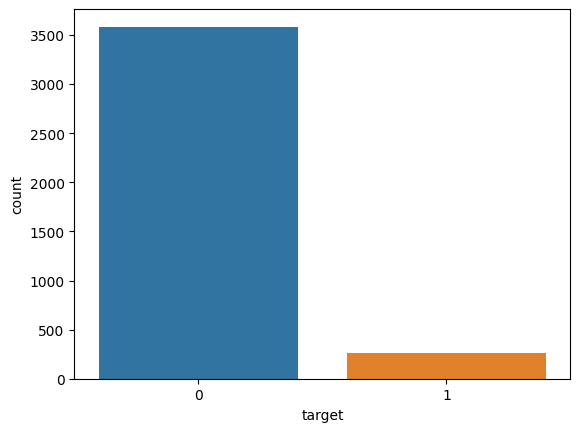

In [15]:
sns.countplot(x=data_custom['target'], label = "pushup")

In [16]:
#sns.pairplot(data_custom, hue= 'target',vars=["linAccX_mean", "linAccY_mean", "linAccZ_mean"])

## TREATING THE IMBALANCE 

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


# Separate the minority and majority classes
minority_class = data_custom[data_custom['target'] == 1]  
majority_class = data_custom[data_custom['target'] == 0]  

# Downsample the majority class 
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Concatenate BOTH
balanced_data = pd.concat([minority_class, majority_downsampled])

# SPLIT the data into features (X) and target variable (y)
X = balanced_data.drop('target', axis=1)  # Assuming 'target' is the column to be predicted
y = balanced_data['target']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Display shapes of the split datasets
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

Shapes - X_train: (399, 99) X_test: (133, 99) y_train: (399,) y_test: (133,)


## KBEST + SCALER

In [18]:
selected = SelectKBest(score_func=f_classif, k=9)
X_train_selected=selected.fit_transform(X_train, y_train)
X_test_selected = selected.transform(X_test) 

In [19]:
# Scale Data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_selected) #ONLY USING SELECTED VARIABLES

X_test_full = scaler.transform(X_test_selected)

##SAVING MODELS

In [20]:
results_hard = {}
results_soft = {}

## SVM

In [21]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [22]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
svm = SVC(probability=True)

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear']}


# Realizar la búsqueda aleatoria de hiperparámetros
random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    n_iter=5,  
    scoring="roc_auc",  
    n_jobs=7,
    return_train_score=True
)
random_search_svm.fit(X_train_full, y_train)

RandomizedSearchCV(estimator=SVC(probability=True), n_iter=5, n_jobs=7,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear']},
                   return_train_score=True, scoring='roc_auc')

In [23]:
#Evaluate: TRAIN
proba_train = random_search_svm.predict_proba(X_train_full)
pred_train = random_search_svm.predict(X_train_full)
print(classification_report(y_train,pred_train))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       199
           1       0.90      0.96      0.93       200

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399



In [24]:
#Evaluate: TEST
proba_test = random_search_svm.predict_proba(X_test_full)
pred_test = random_search_svm.predict(X_test_full)
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        67
           1       0.86      0.94      0.90        66

    accuracy                           0.89       133
   macro avg       0.90      0.90      0.89       133
weighted avg       0.90      0.89      0.89       133



## ANOTHER APPROACH

In [25]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid, scoring='f1', cv=6)  
grid_search.fit(X_train_full, y_train)  

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

# Use the best model for prediction on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_full)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best F1 Score (Cross-validation):", best_f1)
print("F1 Score on Test Set:", f1_test)


Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best F1 Score (Cross-validation): 0.9308311077033385
F1 Score on Test Set: 0.9285714285714285


In [26]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['linear']}

grid= GridSearchCV(SVC(), param_grid, refit=True, verbose= 10)

grid.fit(X_train_full, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START C=0.1, gamma=1, kernel=linear...............................
[CV 1/5; 1/9] END C=0.1, gamma=1, kernel=linear;, score=0.875 total time=   0.0s
[CV 2/5; 1/9] START C=0.1, gamma=1, kernel=linear...............................
[CV 2/5; 1/9] END C=0.1, gamma=1, kernel=linear;, score=0.925 total time=   0.0s
[CV 3/5; 1/9] START C=0.1, gamma=1, kernel=linear...............................
[CV 3/5; 1/9] END C=0.1, gamma=1, kernel=linear;, score=0.912 total time=   0.0s
[CV 4/5; 1/9] START C=0.1, gamma=1, kernel=linear...............................
[CV 4/5; 1/9] END C=0.1, gamma=1, kernel=linear;, score=0.850 total time=   0.0s
[CV 5/5; 1/9] START C=0.1, gamma=1, kernel=linear...............................
[CV 5/5; 1/9] END C=0.1, gamma=1, kernel=linear;, score=0.949 total time=   0.0s
[CV 1/5; 2/9] START C=0.1, gamma=0.1, kernel=linear.............................
[CV 1/5; 2/9] END C=0.1, gamma=0.1, kernel=linear

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             verbose=10)

In [27]:
grid_predictions= grid.predict(X_test_full)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        67
           1       0.86      0.94      0.90        66

    accuracy                           0.89       133
   macro avg       0.90      0.90      0.89       133
weighted avg       0.90      0.89      0.89       133



## LOGISTIC REGRESSION

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Instantiate the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Fit the model on the resampled training data
logistic_model.fit(X_train_full, y_train)

# Predict on the test set
y_pred = logistic_model.predict(X_test_full)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        67
           1       0.86      0.92      0.89        66

    accuracy                           0.89       133
   macro avg       0.89      0.89      0.89       133
weighted avg       0.89      0.89      0.89       133



## XGBOOST

In [29]:
import xgboost as xgb
xgb = xgb.XGBClassifier()

In [30]:
param_dist = {
    'n_estimators': range(1500, 1800, 2000), 
    'max_depth': range(10, 15, 20),
    'booster': ['gbtree', 'gblinear'],
    'min_child_weight': range(1, 2, 3),  
    'learning_rate': [0.1, 0.15, 0.20],
    'gamma': [0, 0.1, 0.2, 0.3]
}

#hyperparameters
random_search_XGB = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=2, #4
    scoring="roc_auc",  
    n_jobs=5, #7
    return_train_score=True
)

In [31]:
# w/o scaling 
random_search_XGB.fit(X_train_selected, y_train)

c:\Users\jdiaz\anaconda3\envs\pycaret\lib\site-packages\xgboost\core.py:160: UserWarning: [18:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=2, n_jobs=5,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.1, 0.15, 0.2],
                                        'max_depth': range(10, 15, 20),
                                        'min_child_weight': range(1, 2, 3),
                                        'n_estimators': range(1500, 1800, 2000)},
                   return_train_score=True, scoring='roc_auc')

In [32]:
print(random_search_XGB.best_params_)

{'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'booster': 'gblinear'}


In [33]:
# train
proba_train_XGB = random_search_XGB.predict_proba(X_train_selected)
pred_train_XGB = random_search_XGB.predict(X_train_selected)
print(classification_report(y_train,pred_train_XGB))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       199
           1       0.91      0.94      0.93       200

    accuracy                           0.92       399
   macro avg       0.93      0.92      0.92       399
weighted avg       0.93      0.92      0.92       399



In [34]:
# test
proba_test_XGB = random_search_XGB.predict_proba(X_test_selected)
pred_test_XGB = random_search_XGB.predict(X_test_selected)
print(classification_report(y_test,pred_test_XGB))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        67
           1       0.86      0.94      0.90        66

    accuracy                           0.89       133
   macro avg       0.90      0.90      0.89       133
weighted avg       0.90      0.89      0.89       133



## NAIVE BAYES

In [35]:
from sklearn.naive_bayes import GaussianNB
gaus = GaussianNB()
param_dist_NB = {
    'priors': [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2],[0.3, 0.7],[0.7, 0.3]]
}


random_search_NB = RandomizedSearchCV(
    estimator=gaus,
    param_distributions=param_dist_NB,
    n_iter=5,  
    scoring="roc_auc",  
    n_jobs=7,
    return_train_score=True
)

In [36]:
# Entrenar el modelo con la búsqueda aleatoria de hiperparámetros
random_search_NB.fit(X_train_full, y_train)

RandomizedSearchCV(estimator=GaussianNB(), n_iter=5, n_jobs=7,
                   param_distributions={'priors': [[0.2, 0.8], [0.5, 0.5],
                                                   [0.8, 0.2], [0.3, 0.7],
                                                   [0.7, 0.3]]},
                   return_train_score=True, scoring='roc_auc')

In [37]:
print(random_search_NB.best_params_)

{'priors': [0.2, 0.8]}


In [38]:
#First evaluate on train
proba_train_NB = random_search_NB.predict_proba(X_train_full)
pred_train_NB = random_search_NB.predict(X_train_full)
print(classification_report(y_train,pred_train_NB))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       199
           1       0.87      0.96      0.91       200

    accuracy                           0.91       399
   macro avg       0.91      0.91      0.91       399
weighted avg       0.91      0.91      0.91       399



In [39]:
#now I will check with the test
proba_test_NB = random_search_NB.predict_proba(X_test_full)
pred_test_NB = random_search_NB.predict(X_test_full)
print(classification_report(y_test,pred_test_NB))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88        67
           1       0.83      0.97      0.90        66

    accuracy                           0.89       133
   macro avg       0.90      0.89      0.89       133
weighted avg       0.90      0.89      0.89       133



## Model evaluation

In [ ]:
pred_SV = random_search_svm.predict(X_test_full)
proba_SV = random_search_svm.predict_proba(X_test_full)
results_hard["Support_Vector"] = pred_SV
results_soft["Support_Vector"] = proba_SV[:,1]

proba_logistic = logistic_model.predict_proba(X_test_full)
pred_logistic = logistic_model.predict(X_test_full)
results_hard["Logistic_Regr"] = pred_logistic
results_soft["Logistic_Regr"] = proba_logistic[:,1]

proba_XGB = random_search_XGB.predict_proba(X_test_selected)
pred_XGB = random_search_XGB.predict(X_test_selected)
results_hard["XGBOOST"] = pred_XGB
results_soft["XGBOOST"] = proba_XGB[:,1]

proba_NB = random_search_NB.predict_proba(X_test_full)
pred_NB = random_search_NB.predict(X_test_full)
results_hard["Naive_Bayes"] = pred_NB
results_soft["Naive_Bayes"] = proba_NB[:,1]

results_hard = pd.DataFrame(results_hard)
results_soft = pd.DataFrame(results_soft)

In [ ]:
metrics = {}

metrics["Accuracy"] = {
    "Naive_Bayes": accuracy_score(y_test, results_hard.Naive_Bayes),
    "Support_Vector": accuracy_score(y_test, results_hard.Support_Vector),
    "XGBOOST": accuracy_score(y_test, results_hard.XGBOOST),
    "Logistic_Regr": accuracy_score(y_test, results_hard.Logistic_Regr)
}
metrics["Precision"] = {
    "Naive_Bayes": precision_score(y_test, results_hard.Naive_Bayes),
    "Support_Vector": precision_score(y_test, results_hard.Support_Vector),
    "XGBOOST": precision_score(y_test, results_hard.XGBOOST),
    "Logistic_Regr": precision_score(y_test, results_hard.Logistic_Regr)
}
metrics["Recall"] = {
    "Naive_Bayes": recall_score(y_test, results_hard.Naive_Bayes),
    "Support_Vector": recall_score(y_test, results_hard.Support_Vector),
    "XGBOOST": recall_score(y_test, results_hard.XGBOOST),
    "Logistic_Regr": recall_score(y_test, results_hard.Logistic_Regr)
}
metrics["F1"] = {
    "Naive_Bayes": f1_score(y_test, results_hard.Naive_Bayes),
    "Support_Vector": f1_score(y_test, results_hard.Support_Vector),
    "XGBOOST": f1_score(y_test, results_hard.XGBOOST),
    "Logistic_Regr": f1_score(y_test, results_hard.Logistic_Regr)
}

metrics = pd.DataFrame(metrics)
metrics

## ROC Curves

In [ ]:
# Datos de FPR y TPR para los tres modelos 
fpr_Naive_Bayes,tpr_Naive_Bayes,_ = roc_curve(y_test, results_soft.Naive_Bayes)
fpr_Support_Vector,tpr_Support_Vector,_ = roc_curve(y_test, results_soft.Support_Vector)
fpr_XGBOOST,tpr_XGBOOST,_ = roc_curve(y_test, results_soft.XGBOOST)
fpr_Logistic_Reg,tpr_Logistic_Regr,_ = roc_curve(y_test, results_soft.Logistic_Regr)

# Calcular el área bajo la curva ROC (AUC) para cada modelo
auc_Naive_Bayes = auc(fpr_Naive_Bayes,tpr_Naive_Bayes)
auc_Support_Vector = auc(fpr_Support_Vector,tpr_Support_Vector)
auc_XGBOOST = auc(fpr_XGBOOST,tpr_XGBOOST)
auc_Logistic_Regr = auc(fpr_Logistic_Reg,tpr_Logistic_Regr)

In [ ]:
# Crear la gráfica ROC
plt.figure(figsize=(8, 6))

# Graficar las curvas ROC para los tres modelos
plt.plot(fpr_Naive_Bayes,tpr_Naive_Bayes, label=f'Naive bayes (AUC = {auc_Naive_Bayes:.2f})')
plt.plot(fpr_XGBOOST,tpr_XGBOOST, label=f'Xgboost (AUC = {auc_XGBOOST:.2f})')
plt.plot(fpr_Support_Vector,tpr_Support_Vector, label=f'Support Vector (AUC = {auc_Support_Vector:.2f})')
plt.plot(fpr_Logistic_Reg,tpr_Logistic_Regr, label=f'Support Vector (AUC = {auc_Logistic_Regr:.2f})')


# Configurar la gráfica
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Modelos')
plt.legend(loc="lower right")

# Mostrar la gráfica
plt.show()